In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(784,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Constants
num_clients = 100  # Number of clients
B = 10  # Local minibatch size
E = 5   # Number of local epochs
learning_rate = 0.01
C = 0.1  # Fraction of clients to use in each round

# Initialize w0
w = model.get_weights()

# Define client update function
def client_update(client_idx, w, B, E, learning_rate):
    client_x = x_train[client_idx * B : (client_idx + 1) * B]
    client_y = y_train[client_idx * B : (client_idx + 1) * B]

    for _ in range(E):
        with tf.GradientTape() as tape:
            logits = model(client_x)
            loss_value = tf.keras.losses.sparse_categorical_crossentropy(client_y, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        for i in range(len(gradients)):
            gradients[i] *= (1.0 / B)
        for i in range(len(w)):
            w[i] -= learning_rate * gradients[i]

# Lists to store round numbers and corresponding test accuracies
rounds_list = []
test_acc_list = []

# Federated averaging training loop
num_rounds = 10
for t in range(num_rounds):
    m = max(int(C * num_clients), 1)
    selected_clients = np.random.choice(num_clients, m, replace=False)

    client_updates = []
    for k in selected_clients:
        client_update(k, w, B, E, learning_rate)
        client_updates.append(w)

    averaged_weights = np.mean(client_updates, axis=0)
    w = averaged_weights
    model.set_weights(w)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Store results
    rounds_list.append(t + 1)
    test_acc_list.append(test_acc)

    print(f"Round {t + 1} - Test accuracy: {test_acc:.4f}")

Round 1 - Test accuracy: 0.2952
Round 2 - Test accuracy: 0.3794
Round 3 - Test accuracy: 0.5672
Round 4 - Test accuracy: 0.5905
Round 5 - Test accuracy: 0.5743
Round 6 - Test accuracy: 0.5700
Round 7 - Test accuracy: 0.6323
Round 8 - Test accuracy: 0.6410
Round 9 - Test accuracy: 0.6890
Round 10 - Test accuracy: 0.6264


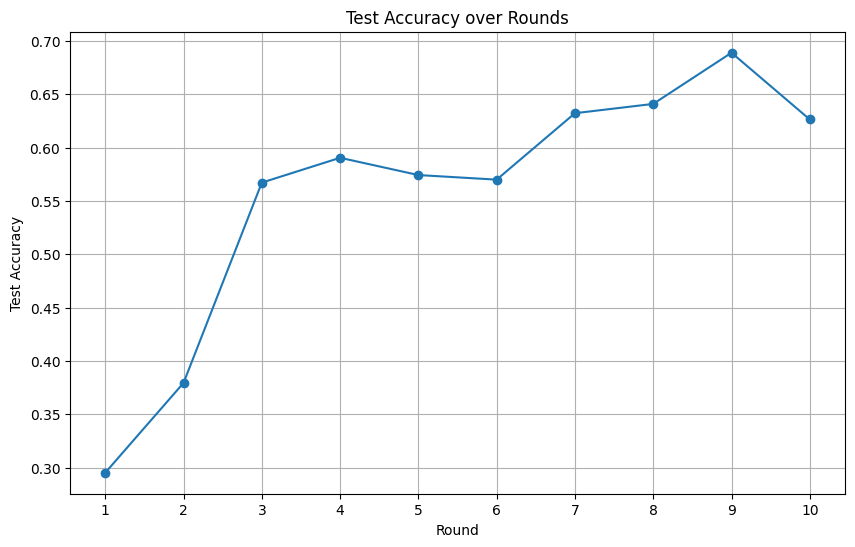

In [ ]:
# Plot the test accuracy over rounds
plt.figure(figsize=(10, 6))
plt.plot(rounds_list, test_acc_list, marker='o')
plt.title("Test Accuracy over Rounds")
plt.xlabel("Round")
plt.ylabel("Test Accuracy")
plt.xticks(rounds_list)
plt.grid(True)
plt.show()